# Basic experiment over walk, run and bike ride

In [1]:
import sys
import warnings
import math as m
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf

import scipy
from scipy.signal import find_peaks
from scipy.spatial import distance_matrix

sys.path.insert(0, "./../")
from qppe.visuals import (
    plot_short_timeseries,
    plot_phase_trajectory,
    plot_phase_trajectory_and_phase
)
from qppe.qppe import (
    delay_embedding_matrix,
    QPPE
)
from qppe.acpe import AutoCorrPhaseIdentifier

In [2]:
warnings.simplefilter('ignore')

In [3]:
def prepare_time_series(path, centred = True):
    data = pd.read_csv(path, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    time_series = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        time_series = (time_series - np.mean(time_series))
        
    time_points = (data['time'].values).astype(float).reshape([-1,])
    time_points = np.linspace(0,time_points[-1]-time_points[0],len(time_series))

    return time_series,time_points

In [4]:
path_basic_experiment = ['walk', 'stairs','bike', 'squats']
data_limits = [(7000,14000), (2300,7500), (14260,22548),  (4000,12000)]

100%|██████████| 6501/6501 [00:30<00:00, 210.71it/s] 


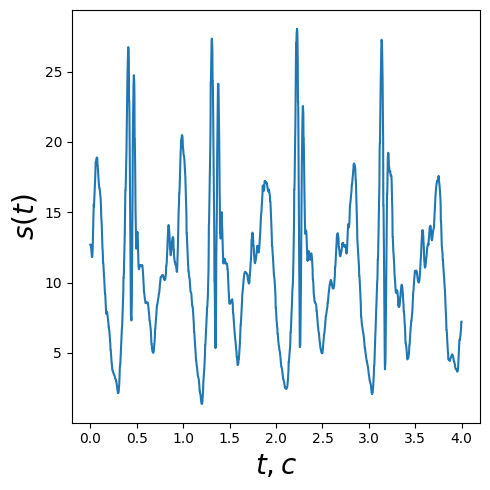

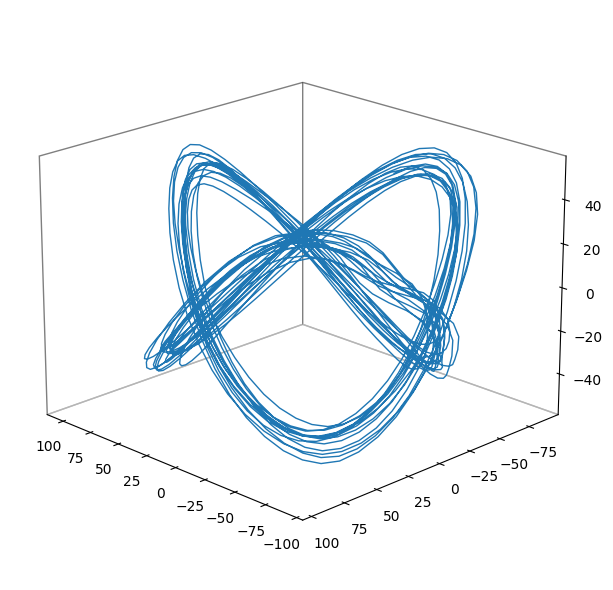

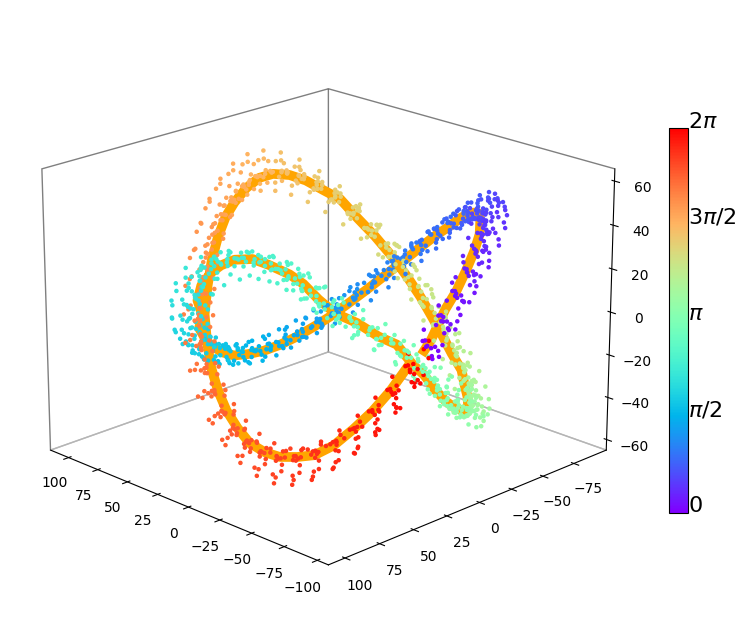

100%|██████████| 4701/4701 [00:22<00:00, 208.38it/s] 


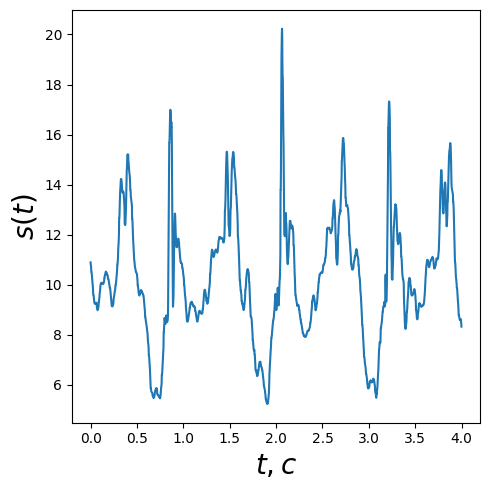

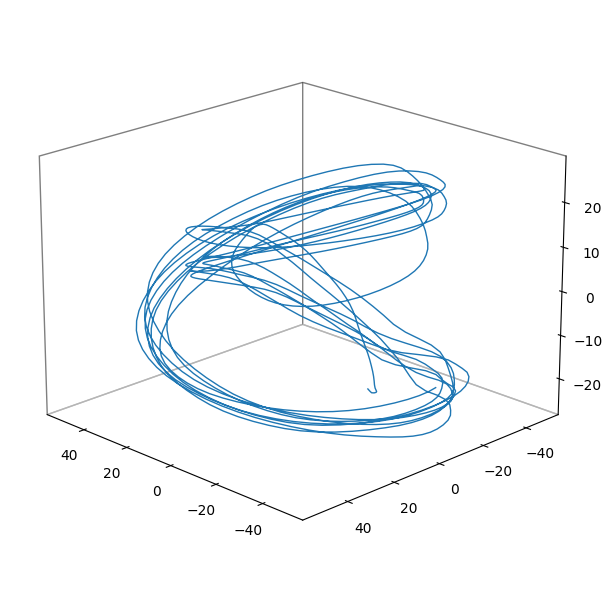

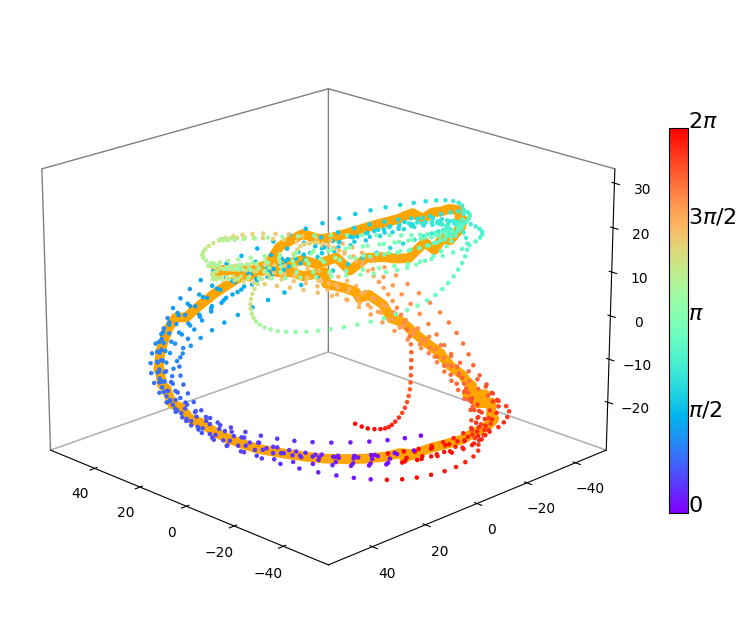

100%|██████████| 7789/7789 [00:34<00:00, 226.24it/s]


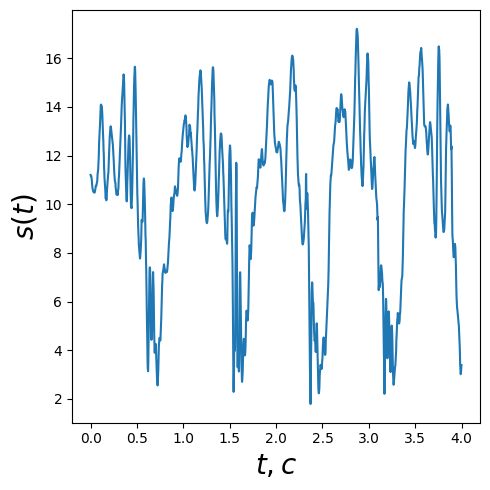

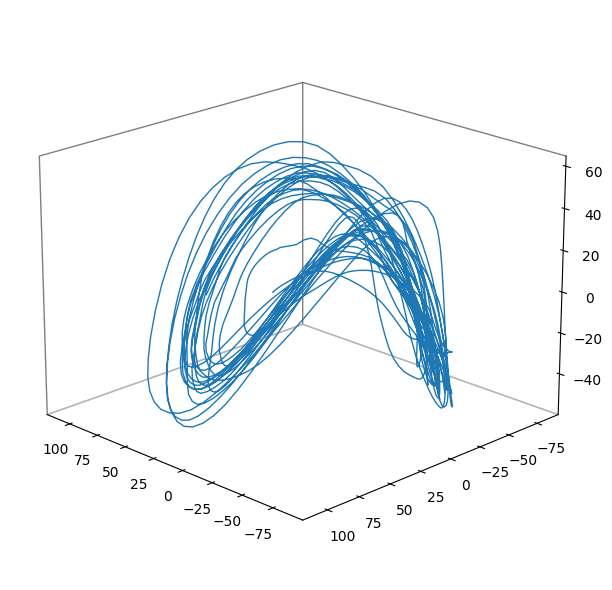

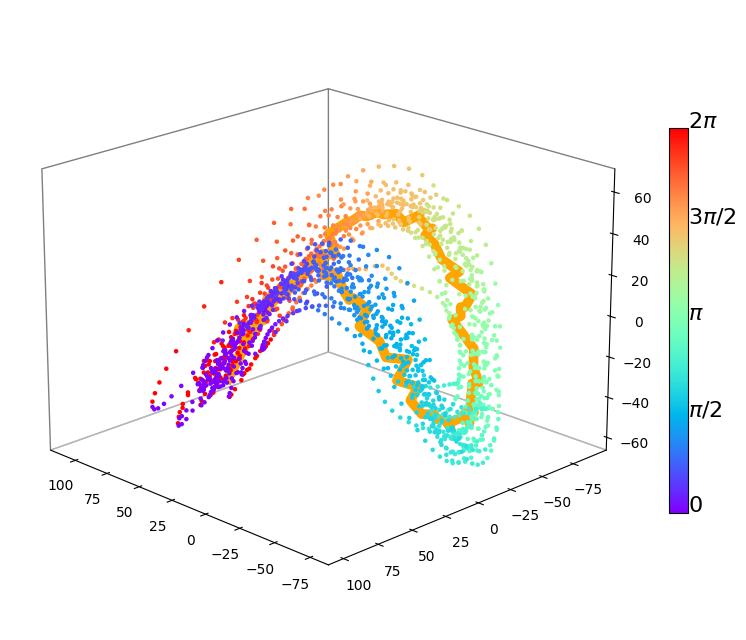

In [5]:
for i in range(3):
    x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[i]}.csv', centred = False)
    x_acc = x_acc[data_limits[i][0]:data_limits[i][1]]
    
    X_h = delay_embedding_matrix(x_acc, 500)
    
    pca = PCA(n_components = 4)
    X_PCA = pca.fit_transform(X_h)
    
    phase_trajectory = X_PCA[::3,:3]
    
    result_dict = QPPE(x = x_acc, update_coef = 3, return_expectation_model = True)
    
    phase_trajectory = X_PCA[::5,:3]
    expextation_values = result_dict['expectation'][:700:5,:3]
    phase_history = result_dict['phase'][::5]
    
    plt.rcParams['figure.figsize'] = 5, 5
    plot_short_timeseries(x_acc[:2000], 500, path = f'./../images/2_1_sample_{path_basic_experiment[i]}.png')
    plt.show()
    
    plt.rcParams['figure.figsize'] = 6, 6
    plot_phase_trajectory(phase_trajectory, path = f'./../images/2_2_traj_{path_basic_experiment[i]}.png')
    plt.show()
    
    plt.rcParams['figure.figsize'] = 10, 10
    plot_phase_trajectory_and_phase(
        phase_trajectory,
        expextation_values,
        phase_history,
        rotation = (0, 30, 0),
        path = f'./../images/2_3_phase_{path_basic_experiment[i]}.png'
    )
    plt.show()

In [9]:
def plot_signal_phases(x_acc, phases, freq=500, path=None):
    def _scatter_phase(y, name, phase, ax, ax_phase, freq=500):
        # no labels

        # now determine nice limits by hand:
        binwidth = 0.25
        #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        #lim = (int(xymax/binwidth) + 1) * binwidth

        ax_phase.plot(phase, label=name)
        ax_phase.set_xticks(np.arange(len(y))[::freq])
        ax_phase.set_xticklabels(np.round(np.arange(len(y))/freq, 2)[::freq])


    left, width = 0.1, 1.
    bottom, height = 0.1, 0.3
    spacing = 0.005


    rect_plot = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]

    # start with a square Figure
    fig = plt.figure(figsize=(7, 10))

    ax = fig.add_axes(rect_histx)
    ax.tick_params(axis="x", labelbottom=False)
    ax.set_ylabel('$s(t)$', size=20)
    # the scatter plot:
    ax.plot(x_acc)
    ax_phasex = fig.add_axes(rect_plot, sharex=ax)
    ax_phasex.set_yticks(np.linspace(0, 2*np.pi, 9))
    ax_phasex.set_yticklabels([r"0", r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$", r"$\pi$",r"$5\pi/4$",r"$3\pi/2$",r"$7\pi/4$",r"$2\pi$"])
    ax_phasex.set_xlabel('$t,c$', size=20)
    ax_phasex.set_ylabel('$\phi(t)$', size=20)

    # use the previously defined function
    for name, phase in phases.items():
        _scatter_phase(x_acc, name, phase, ax, ax_phasex, freq=freq)
    ax_phasex.legend(loc = 'upper right')#bbox_to_anchor=(0, 1))
    if path is not None:
        fig.tight_layout()
        fig.savefig(path, dpi=200, bbox_inches='tight')
    return fig

100%|██████████| 7501/7501 [00:49<00:00, 151.20it/s] 


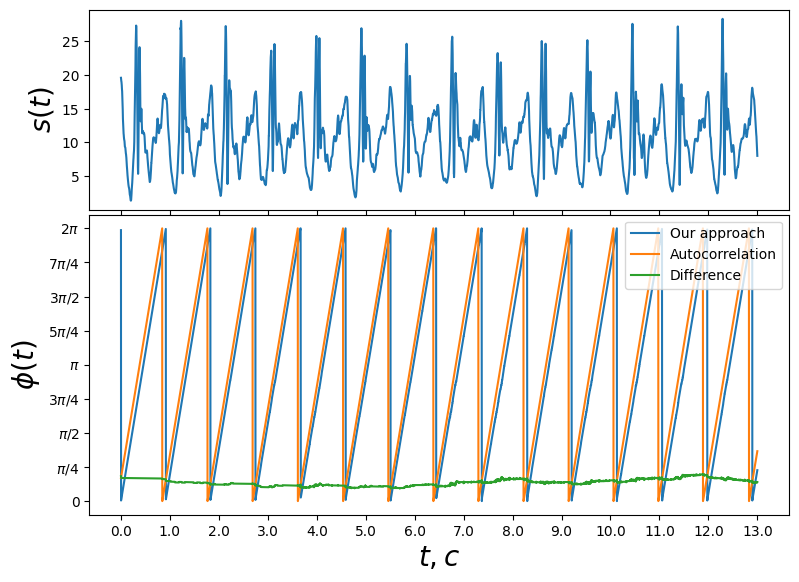

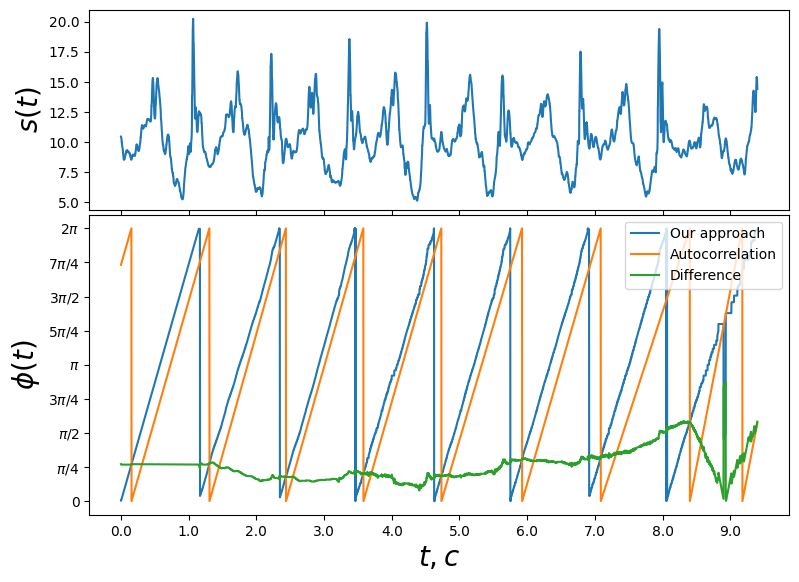

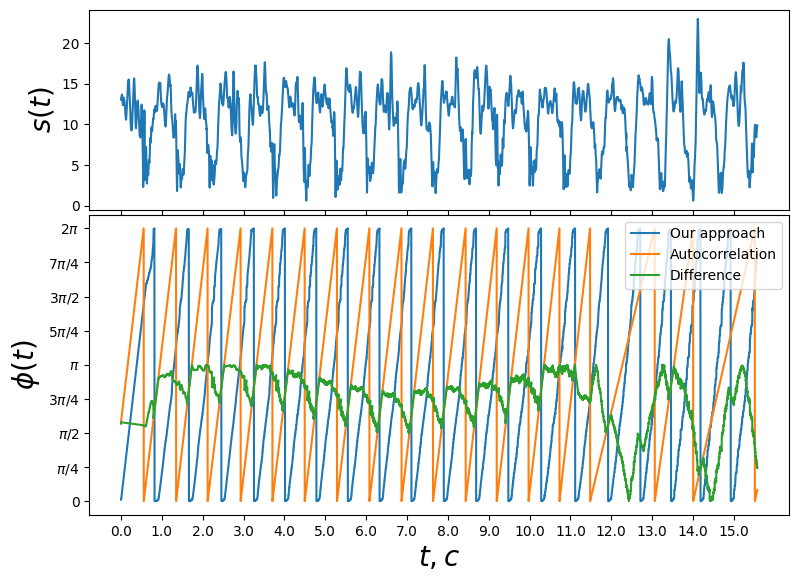

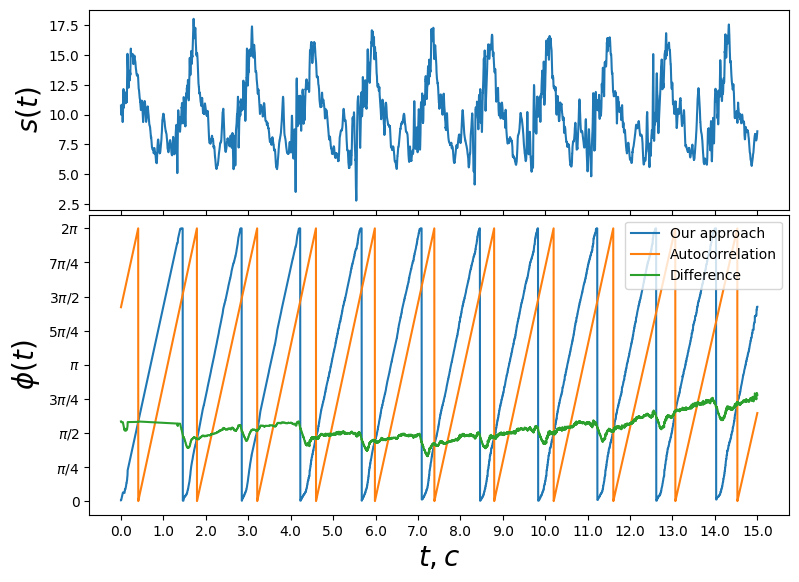

In [10]:
for i in range(4):
    x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[i]}.csv', centred = False)
    x_acc = x_acc[data_limits[i][0]:data_limits[i][1]]
    nlags = 500
    
    result_dict = QPPE(
        x = x_acc,
        update_coef = 3,
        return_expectation_model = True)
    
    autocorr_phase = AutoCorrPhaseIdentifier(x = x_acc, period = nlags)
    
    _phase = result_dict['phase']
    _phase_autocorr = autocorr_phase[nlags-1:]
    
    fig = plot_signal_phases(
        x_acc[nlags-1:],
        {
            "Our approach": _phase,
            "Autocorrelation": _phase_autocorr,
            "Difference": np.arccos(np.cos(_phase-_phase_autocorr))},
        path = f'./../images/2_difference_{path_basic_experiment[i]}.png'
    )